# Hard
- Test Environment: Windows 10, py-visa, NI-VISA


## TODO:

Testing on more platforms:

- x86, ubuntu-18.04.
- raspberrypi4.
- FreeBSD.

In [4]:
import time
import mhs5200

In [5]:
signal_gen_port = "COM4"
oscilloscope_port = scope_port = 'USB0::0x1AB1::0x0588::DS1EU152500705::INSTR'

In [6]:
import mhs5200.Enums

In [7]:
with mhs5200.MHS5200(signal_gen_port) as signal_generator:
    for channel in signal_generator.channels:
        channel.amplitude=1
        channel.duty_cycle=50
        channel.frequency=1
        channel.offset=0
        channel.phase=0
        channel.wave=mhs5200.Enums.SQUARE

In [8]:
import pyvisa
rm = pyvisa.ResourceManager()
rm.list_resources()

scope = rm.open_resource(oscilloscope_port)

In [9]:
import uuid

In [10]:
class Scope():
    def __init__(self, *args, oscilloscope=None, oscilloscope_port=None):
        if oscilloscope_port is not None:
            self.resource = rm.open_resource(oscilloscope_port)
        else:
            self.resource = oscilloscope
            
        for fcn in ["write", "query", "close", "query_ascii_values"]:
            setattr(self, fcn, getattr(self.resource, fcn))
        
    def __enter__(self):
        return self
    
    def __exit__(self, type, value, tb):
        t1=time.time()
        try:
            while True:
                if time.time()>t1+5:
                    break
                self.close()
                time.sleep(0.2)
        except InvalidSession:
            pass
        except:
            raise

In [11]:
scope = Scope(oscilloscope_port=oscilloscope_port)

In [12]:
scope = Scope(oscilloscope_port=oscilloscope_port)

In [13]:
scope.close()

In [14]:
import pandas as pd

In [15]:
def test_frequency_amplitude3(frequency, amplitude, signal_gen, scope):
    for chan in signal_gen.channels:
        chan.frequency=frequency
        chan.amplitude=amplitude
        chan.phase=0
    
    period = 1/float(frequency)
    timescale="{:.20f}".format(float(period/5))
    # Configure scope
    
    scope.write(f":MEASURE:TOTAL ON")
    scope.write(f":TIMebase:SCALE {timescale}")
    for scope_channel in [1, 2]:
        scope.write(f":CHANNEL{scope_channel}:probe 1")
        scope.write(f":CHANNEL{scope_channel}:scale {amplitude/5}")
        scope.write(f":CHANNEL{scope_channel}:offset 0")
    # Configure signal generator
    for chan in signal_gen.channels:
        chan.frequency=frequency
        chan.amplitude=amplitude
        chan.offset = 0
        chan.phase=0

    df = dict()
    df["uuid"] = str(uuid.uuid4())
    df["frequency"] = frequency
    df["amplitude"] = amplitude
    for source in ["CHAN1", "CHAN2"]:
        scope.write(f":MEASURE:SOURCE {source}")
        time.sleep(1)
        for param in ['VPP',
                        'VMAX',
                        'VMIN',
                        'VAMPlitude',
                        'VTOP',
                        'VBASe',
                        'VAVerage',
                        'VRMS',
                        'OVERshoot',
                        'PREShoot',
                        'FREQuency',
                        'RISetime',
                        'FALLtime',
                        'PERiod',
                        'PWIDth',
                        'NWIDth',
                        'PDUTycycle',
                        'NDUTycycle',
                        'PDELay',
                        'NDELay',
                        'TOTal',
                        'SOURce',]:
            try:
                measured = scope.query_ascii_values(f":MEASURE:{param}?")[0]
            except:
                measured = scope.query(f":MEASURE:{param}?")[0]

            df[f"{source}_{param}"] = measured
    return pd.DataFrame(df, index=[0])

In [17]:
df = pd.DataFrame()
with mhs5200.MHS5200(signal_gen_port) as signal_gen:
    with Scope(oscilloscope_port=oscilloscope_port) as scope:
        for frequency in [1, 10, 100]:
            for amplitude in [1, 10, 20]:
                result_df = test_frequency_amplitude3(frequency, amplitude, signal_gen=signal_gen, scope=scope)
                df = df.append(result_df)

In [18]:
import seaborn as sns

sns.set(
    rc={
        "figure.figsize": (11, 8.5),
        "figure.dpi": 300,
        "figure.facecolor": "w",
        "figure.edgecolor": "k",
    }
)
palette = (sns.color_palette("Paired"))
sns.palplot(palette)
sns.set_palette(palette)

In [23]:
df.groupby(["frequency", "amplitude"]).mean()

CHAN1_VPP  CHAN1_VMAX  CHAN1_VMIN  CHAN1_VAMPlitude  \
frequency amplitude                                                        
1         1              1.060       0.528      -0.528             0.991   
          10             1.040       0.560      -0.480             0.884   
          20            10.600       5.280      -5.280            10.300   
10        1              0.976       0.496      -0.480             0.950   
          10            10.600       5.280      -5.280            10.400   
          20            21.000      10.600     -10.400            20.600   
100       1              0.984       0.496      -0.488             0.963   
          10            10.600       5.280      -5.360            10.400   
          20            21.100      10.700     -10.400            20.700   

                     CHAN1_VTOP  CHAN1_VBASe  CHAN1_VAVerage  CHAN1_VRMS  \
frequency amplitude                                                        
1         1               0.520       -0.471        0.000413       0.497   
          10              0.438       -0.446        0.006400       0.431   
          20              5.120       -5.190       -0.015500       5.070   
10        1               0.481       -0.469        0.005470       0.476   
          10              5.200       -5.200       -0.022000       5.200   
          20             10.400      -10.200        0.044300      10.300   
100       1               0.492       -0.472        0.005840       0.479   
          10              5.220       -5.220       -0.020100       5.220   
          20             10.400      -10.300        0.049100      10.300   

                     CHAN1_OVERshoot  CHAN1_PREShoot        ...         \
frequency amplitude                                         ...          
1         1                  0.00000        0.000000        ...          
          10                 0.04700        0.047000        ...          
          20                 0.00000        0.000000        ...          
10        1                  0.01540        0.015400        ...          
          10                 0.00751        0.000188        ...          
          20                 0.00763        0.000126        ...          
100       1                  0.00447        0.004470        ...          
          10                 0.00560        0.005600        ...          
          20                 0.00584        0.005840        ...          

                     CHAN2_VAVerage  CHAN2_VRMS  CHAN2_OVERshoot  \
frequency amplitude                                                
1         1                -0.00269      0.0537     3.840000e-02   
          10               -0.02000      0.5540     9.470000e-02   
          20               -0.01330      0.5060     9.900000e+37   
10        1                -0.00024      0.0518     4.040000e-02   
          10               -0.00840      0.5480     8.990000e-02   
          20               -0.00907      1.1000     1.350000e-02   
100       1                -0.00040      0.0518     4.170000e-02   
          10               -0.00493      0.5540     7.830000e-02   
          20                0.00320      1.1100     7.260000e-02   

                     CHAN2_PREShoot  CHAN2_FREQuency  CHAN2_PERiod  \
frequency amplitude                                                  
1         1            3.840000e-02     9.960000e-01  1.000000e+00   
          10           9.470000e-02     9.920000e-01  1.010000e+00   
          20           9.900000e+37     9.900000e+37  9.900000e+37   
10        1            4.040000e-02     1.000000e+01  9.990000e-02   
          10           1.700000e-02     1.000000e+01  9.990000e-02   
          20           8.640000e-02     1.000000e+01  9.990000e-02   
100       1            4.170000e-02     1.000000e+02  1.000000e-02   
          10           7.830000e-02     1.000000e+02  1.000000e-02   
          20           5.810000e-04     1.000000e+02  1.000000e-02   

            

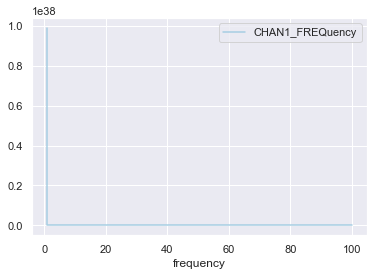

In [27]:
df.plot(x="frequency", y="CHAN1_FREQuency")

In [28]:
df2=df[df.CHAN1_FREQuency<2000]

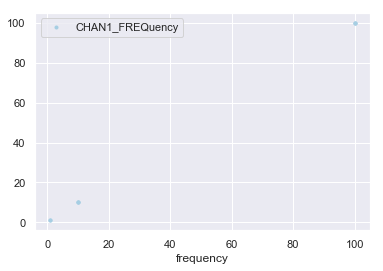

In [32]:
df2.plot(x="frequency", y="CHAN1_FREQuency", style=".")

In [34]:
df3=df[df.frequency==1]

In [38]:
df3[["frequency", "CHAN1_FREQuency"]]

,frequency,CHAN1_FREQuency
0,1,9.900000e+37
0,1,9.840000e-01
0,1,9.920000e-01


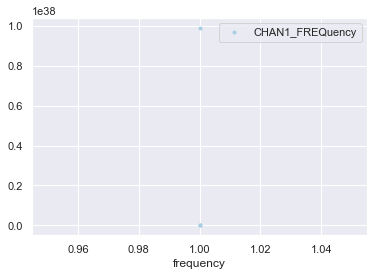

In [35]:
df3.plot(x="frequency", y="CHAN1_FREQuency", style=".")

In [41]:
df3=df[df.frequency==10]
df3[["frequency", "CHAN1_FREQuency"]]

,frequency,CHAN1_FREQuency
0,10,10.0
0,10,10.0
0,10,10.0


In [ ]:
data = scope.query_binary_values(":WAVEFORM:DATA? CHAN1")
plt.plot(data)

In [ ]:
df = pd.DataFrame()
with mhs5200.MHS5200(signal_gen_port) as signal_gen:
    with Scope(oscilloscope_port=oscilloscope_port) as scope:
        for frequency in [1, 10, 100]:
            for amplitude in [1, 10, 20]:
                result_df = test_frequency_amplitude3(frequency, amplitude, signal_gen=signal_gen, scope=scope)
                df = df.append(result_df)

In [44]:
import numpy as np

In [46]:
np.log10(100000)

5.0

In [45]:
np.log10(1000)

3.0

In [48]:
df = pd.DataFrame()
with mhs5200.MHS5200(signal_gen_port) as signal_gen:
    with Scope(oscilloscope_port=oscilloscope_port) as scope:
        for frequency in np.logspace(np.log10(100), np.log10(10000000), 50):
            for amplitude in range(20):
                print(f"{frequency}:{amplitude}")
                result_df = test_frequency_amplitude3(frequency, amplitude, signal_gen=signal_gen, scope=scope)
                df = df.append(result_df)
                
            pd.to_pickle(df, "lab_log_data.pickle")

100.0:0
100.0:1
100.0:2
100.0:3
100.0:4
100.0:5
100.0:6
100.0:7
100.0:8
100.0:9
100.0:10
100.0:11
100.0:12
100.0:13
100.0:14
100.0:15
100.0:16
100.0:17
100.0:18
100.0:19
126.48552168552958:0
126.48552168552958:1
126.48552168552958:2
126.48552168552958:3
126.48552168552958:4
126.48552168552958:5
126.48552168552958:6
126.48552168552958:7
126.48552168552958:8
126.48552168552958:9
126.48552168552958:10
126.48552168552958:11
126.48552168552958:12
126.48552168552958:13
126.48552168552958:14
126.48552168552958:15
126.48552168552958:16
126.48552168552958:17
126.48552168552958:18
126.48552168552958:19
159.98587196060572:0
159.98587196060572:1
159.98587196060572:2
159.98587196060572:3
159.98587196060572:4
159.98587196060572:5
159.98587196060572:6
159.98587196060572:7
159.98587196060572:8
159.98587196060572:9
159.98587196060572:10
159.98587196060572:11
159.98587196060572:12
159.98587196060572:13
159.98587196060572:14
159.98587196060572:15
159.98587196060572:16
159.98587196060572:17
159.9858719606

SerialException: ClearCommError failed (PermissionError(13, 'Access is denied.', None, 5))

In [ ]:
data = scope.query_binary_values(":WAVEFORM:DATA? CHAN2")
s

In [ ]:
scope.query(":ACQ:SAMP? CHANnel2")

In [ ]:
scope.query(":ACQ:MEMD?")

In [ ]:
scope.write(":ACQ:MEMD LONG")

In [ ]:
for depth in ["NORMAL", "LONG"]:
    scope.write(f":ACQ:MEMD {depth}")
    time.sleep(0.5)
    assert depth == scope.query(":ACQ:MEMD?")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data = scope.query_binary_values(":WAVEFORM:DATA? CHAN1", "B")
plt.plot(data)

In [ ]:
data = scope.query_binary_values(":WAVEFORM:DATA? CHAN2", "B")
plt.plot(data)

In [ ]:
scope.q

In [ ]:
?scope.query_binary_values

In [ ]:
scope.query(":WAVEFORM:POINTS:MODE?")

In [ ]:
scope.write(":WAVEFORM:DATA? CHANNEL1")
header = scope.read_raw()[:10]
header

In [ ]:
scope.write(":WAVEFORM:DATA? CHANNEL1")
data = scope.read_raw()[10:]

In [ ]:
data[0]

In [ ]:
data[0:1]

In [ ]:
data[0:2]

In [ ]:
import numpy as np

In [ ]:
np.array(56).tobytes()

In [ ]:
np.array(56).tobytes("C")

In [ ]:
np.array(56).tobytes("F")

In [ ]:
np.array(56.0).tobytes("F")

In [ ]:
np.frombuffer(np.array(56).tobytes("F"))

In [ ]:
dt = np.dtype(float)
dt = dt.newbyteorder(">")
plt.plot(np.frombuffer(data))

In [ ]:
np.frombuffer(b'\x01\x02', dtype=np.uint8)

In [ ]:
np.frombuffer(b'\x01\x02\x03\x04\x05', dtype=np.uint8, count=3)

In [ ]:
dt = np.dtype(float)
dt = dt.newbyteorder("<")
plt.plot(np.frombuffer(data))